# Job Type classification with a feed forward neural netowrk and CNN
22274048, 23191175

In this assignment three neural net architectures were implemented and trained using three different types of job description word embeddings. Their classification task is to identify Full time jobs. In total three feed forward and six convolutional neural net classifiers were trained and evaluated against one another. The three embedding strategies utilized were one hot encoding, pretrained glove embeddings and a domain specific word2vec model prepared on the data. 

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omriram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Import the necessary modules

In [29]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import pandas as pd
import os
from collections import Counter
import string
from argparse import Namespace
import torch.nn as nn
from torch.utils.data import Dataset
import random
import os
import torch.optim as optim
import json
import torch.nn.functional as F
import pandas as pd
import numpy as np
from argparse import Namespace
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [30]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
script_dir

'/Users/omriram/Desktop/U/cits4012/cits4012_project2'

Find the path to the root directory of the project

In [31]:
args = Namespace(
     processed_csv = os.path.join(script_dir, 'data/processed_seek.csv'),
     word2vec_model_filepath = os.path.join(script_dir, 'model_storage/word2vec'),
)

Load the csv file into a dataframe, the domain specific word2vec model and the pretrained glove model

In [32]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_pretrained = api.load("glove-wiki-gigaword-100")
    #print("Loaded vocab size %i" % len(wv_pretrained.key_to_index))
    print("The loaded object is of type %s" % str(type(wv_pretrained)))
    return wv_pretrained
glove_model = load_embedding_model()

The loaded object is of type <class 'gensim.models.keyedvectors.KeyedVectors'>


In [33]:
word2vec_model = Word2Vec.load(args.word2vec_model_filepath).wv
df = pd.read_csv(args.processed_csv)
df.short_description = df.short_description.apply(lambda x: x.split(' ')) # CSV files cannot store lists so these columns always has to be retokenized
df.job_description = df.job_description.apply(lambda x: x.split(' '))
df = df.sample(frac = 1) # CHANGE, AFFECTS FEED EMBEDDING
df

,category,job_description,job_type_target,short_description,split
2382,Marketing & Communications,"[about, the, business, zuper, is, fintech, bor...",Full Time,"[help, world, create, social, media, pr, media...",train
2861,Information & Communication Technology,"[at, transurban, we, rely, on, our, forward, t...",Full Time,"[transurban, tmre, unified, collaboration, you...",train
17550,"Mining, Resources & Energy","[the, consolidated, minerals, group, consmin, ...",Full Time,"[consmin, manganese, manganese, consmin, manga...",train
6303,"Manufacturing, Transport & Logistics","[mbs, in, matraville, is, looking, for, an, ex...",Full Time,"[mbs, matraville, crane, must, crane, preffere...",train
22363,Trades & Services,"[tully, sugar, limited, tully, sugar, limited,...",Full Time,"[tully, sugar, limited, tully, sugar, limited,...",val
...,...,...,...,...,...
12532,Community Services & Development,"[short, description, unique, grants, manager, ...",Full Time,"[grants, newly, writing, grants, grants, newly...",train
25556,Education & Training,"[multiple, positions, available, we, re, looki...",Full Time,"[multiple, children, childcare, award, hold, q...",test
7508,Retail & Consumer Products,"[we, are, national, footwear, company, and, we...",Other,"[footwear, company, burwood, westfield, wednes...",train
328,Healthcare & Medical,"[rn, een, nurses, for, ipswich, area, we, are,...",Other,"[rn, een, ipswich, rn, een, shifts, comfort, s...",train


## Implementing some helper classes

The below clases are used in the implementaiton of the models in the next section of this notebook

A standard vocabulary object used to look up the token corresponding to some index and vice versa

In [34]:
class Vocabulary(object):
    """Class to process text and extract Vocabulary for mapping"""
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existingmap of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                                for token, idx in self._token_to_idx.items()}
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = 1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}
    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)
    def add_token(self, token):
        """Update mapping dicts based on the token.
        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]
    
    def lookup_token(self, token):
        """Retrieve the index associated with the token
        or the UNK index if token isn't present.
        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
            for the UNK functionality
        """
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
    def lookup_index(self, index):
        """Return the token associated with the index
        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
        KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    def __len__(self):
        return len(self._token_to_idx)

Class used to create a flattened one hot encoded vector for each job descriptions

In [35]:
class One_hot_Vectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, description_vocab, target_vocab):
        """
        Args:
            description_vocab (Vocabulary): maps words to integers
            target_vocab (Vocabulary): maps class labels to integers
        """
        self.description_vocab = description_vocab
        self.target_vocab = target_vocab
    def vectorize(self, description_tokenized):
        """Create a collapsed one hot vector for the job description
        Args:
            description_tokenized (list): the tokenized job description
        Returns:
            one_hot (np.ndarray): the collapsed onehot encoding
        """
        one_hot = np.zeros(len(self.description_vocab), dtype=np.float32)
        for token in description_tokenized:
            if token not in string.punctuation:
                one_hot[self.description_vocab.lookup_token(token)] = 1
        return one_hot
    @classmethod
    def from_dataframe(cls, description_df, target_cat = True, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        Args:
            description_df (pandas.DataFrame): the description dataset
            cutoff (int): the parameter for frequency based filtering
        Returns:
            an instance of the descriptionVectorizer
        """
        description_vocab = Vocabulary(add_unk=True)
        target_vocab = Vocabulary(add_unk=False)
        # adding category or Job_type
        if target_cat:
            for category in sorted(set(description_df.category)):
                target_vocab.add_token(category)
        
        else:
            
            for job_type in  sorted(set(description_df.job_type_target)):
                target_vocab.add_token(job_type)
        # Add top words if count > provided count
        word_counts = Counter()
        for description in description_df.job_description:
            for word in description:
                if word not in string.punctuation:
                    word_counts[word] += 1
        for word, count in word_counts.items():
            if count > cutoff:
                description_vocab.add_token(word)
        return cls(description_vocab, target_vocab)
    @classmethod
    def from_serializable(cls, contents):
        """Intantiate a descriptionVectorizer from a serializable dictionary
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the descriptionVectorizer class
        """
        description_vocab = Vocabulary.from_serializable(contents['description_vocab'])
        target_vocab = Vocabulary.from_serializable(contents['target_vocab'])
        return cls(description_vocab=description_vocab, target_vocab=target_vocab)
    def to_serializable(self):
        """Create the serializable dictionary for caching
        Returns:
            contents (dict): the serializable dictionary
        """
        return {'description_vocab': self.description_vocab.to_serializable(),
                'target_vocab': self.target_vocab.to_serializable()}

Extends the vocabulary class to add tokens for end begining and unknown tokens


In [36]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

The vectorizer class coordinates instantiates the sequence vocabulary class with the provided job descriptions. In addition it creates vectors the size of the longest job description and adds the mask, unknown, begin and end tokens to each vector. The resulting vectors can be used to derive the embedding matrix. 

In [37]:
class Vectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, desc_vocab, target_vocab):
        self.description_vocab = desc_vocab
        self.target_vocab = target_vocab
    def vectorize(self, description, vector_length=-1):
        """
        Args:
            description (list) : tokenized description 
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized description (numpy.array)
        """
        indices = []
        
        
        indices.extend(self.description_vocab.lookup_token(token) 
                       for token in description)
        if vector_length < 0:
            vector_length = len(indices)
        
        out_vector = np.zeros(vector_length, dtype=np.int64)
     
        out_vector[:len(indices)] = indices
       

        return out_vector
      
    def vectorize_one_hot(self, description):
        """Create a collapsed one hot vector for the job description
        Args:
            description_tokenized (list): the tokenized job description
        Returns:
            one_hot (np.ndarray): the collapsed onehot encoding
        """
        one_hot = np.zeros(len(self.description_vocab), dtype=np.float32)
        for token in description:
            if token not in string.punctuation:
                one_hot[self.description_vocab.lookup_token(token)] = 1
        return one_hot

    @classmethod
    def from_dataframe(cls, df, feature_column = 'short_description', target_cat = False, cutoff=10):
        """Instantiate the vectorizer from the dataset dataframe
        Args:
            description_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the descriptionVectorizer
        """
        target_vocab = Vocabulary(add_unk=False)
        if target_cat:
            for target in sorted(set(df.category)):
                target_vocab.add_token(target)    
        else:
            for job_type in sorted(set(df.job_type_target)):
                target_vocab.add_token(job_type)
        
 
        word_counts = Counter()
        for desc in df[feature_column]:
            desc = desc.split(' ') if type(desc) is not list else desc
            for token in desc:
                word_counts[token] += 1

        desc_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                desc_vocab.add_token(word)
        
        return cls(desc_vocab, target_vocab)

    @classmethod
    def from_serializable(cls, contents):
        description_vocab = \
            SequenceVocabulary.from_serializable(contents['description_vocab'])
        target_vocab =  \
            Vocabulary.from_serializable(contents['target_vocab'])

        return cls(description_vocab=description_vocab, target_vocab=target_vocab)

    def to_serializable(self):
        return {'description_vocab': self.description_vocab.to_serializable(),
                'target_vocab': self.target_vocab.to_serializable()}

A standard dataset class used to feed the correct data from the dataframe to the dataloader

In [38]:
class Dataset(Dataset):
    def __init__(self, df, vectorizer, short = True, job_type = True, one_hot = False):
        """
        Args:
            df (pandas.DataFrame): the dataset
            vectorizer (GloveVectorizer): vectorizer instatiated from dataset
        """
        self.one_hot = one_hot
        self.df = df
        self._vectorizer = vectorizer
        self.short = short
        self.job_type = job_type

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context)
        if self.short:
            self._max_seq_length = max(map(measure_len, df.short_description)) + 2
        else:
            self._max_seq_length = max(map(measure_len, df.job_description)) + 2
        
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        if self.job_type:
            class_counts = df.job_type_target.value_counts().to_dict()
        else:
            class_counts = df.category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.target_vocab.lookup_token(item[0])
        

        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_df_and_make_vectorizer(cls, df, short = True, one_hot = False):
        """Load dataset and make a  vectorizer from scratch
        
        Args:
            csv (str): location of the dataset
        Returns:
            an instance of Dataset
        """
        train_df = df[df.split=='train']
        return cls(df, Vectorizer.from_dataframe(train_df), short = short, one_hot = one_hot)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of GloveVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return Vectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]
        if self.one_hot:
            if self.short:
                description_vector = \
                    self._vectorizer.vectorize_one_hot(row.short_description)
            else:
                description_vector = \
                    self._vectorizer.vectorize_one_hot(row.job_description)

        else:
            if self.short:
                description_vector = \
                    self._vectorizer.vectorize(row.short_description, self._max_seq_length)
            else:
                description_vector = \
                    self._vectorizer.vectorize(row.job_description, self._max_seq_length)

        if self.job_type:
            target_index = \
                self._vectorizer.target_vocab.lookup_token(row.job_type_target)
        else:
            target_index = \
                self._vectorizer.target_vocab.lookup_token(row.category)


        return {'x_data': description_vector,
                'y_target': target_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """ 
        return len(self) // batch_size

## Defining some helper functions for training each model

Define some functions for retrieving the embedding matrix to be passed to the classifier class. Each function takes a list of words from the vocabulary in the dataset

In [39]:
def get_matrix_of_vectors(wv_pretrained, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_pretrained: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_pretrained.key_to_index.keys()) # may need to change to key_to_index.keys()
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_pretrained.get_vector(w)) # norm = True
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_pretrained.get_vector(w)) # norm = True
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [40]:
def make_one_hot_matrix(one_hot_vectorizer, words):
    """
    Args: 
        one_hot_vectorizer: of class one_hot_vectorizer 
        words: List of words in the dataset
    Returns:
        A matrix of the embeddings for each word matching the word's index
    """
    embedding_size = len(words)
    final_embeddings = np.zeros((len(words), len(words)))

    for i, word in enumerate(words):
      final_embeddings[i, :] = one_hot_vectorizer.vectorize(word)
    return final_embeddings
    
def make_embedding_matrix(embeddings, word_to_idx, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataseta
    """
    embedding_size = embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [41]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 4,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long().to(cnn_args.device) #.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100
    
def compute_accuracy_BCE(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [42]:
def train_model(classifier, dataset, args,loss_func, BCE = False, one_hot = False):
    """
    args:
    classifier: the pytorch model that will be trained.
    dataset: An object from the dataset class
    returns:
    the classifier and the final trainstate
    """
    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
    
    
    optimizer = optim.Adam(classifier.parameters(), lr = args.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode = 'min', factor=0.5, patience=1)

    train_state = make_train_state(args)

    epoch_bar = tqdm(desc='training routine', 
                            total=args.num_epochs,
                            position=0)

    dataset.set_split('train')
    train_bar = tqdm(desc='split=train',
                            total=dataset.get_num_batches(args.batch_size), 
                            position=1, 
                            leave=True)
    dataset.set_split('val')
    val_bar = tqdm(desc='split=val',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)


    classifier.float() # sets classifier to receive in double precision format
    try:
        
        for epoch in range(args.num_epochs):
            train_state['epoch_index'] = epoch
            dataset.set_split('train')
            batch_generator = generate_batches(dataset, batch_size=args.batch_size, device = args.device)

            running_loss = 0.0
            running_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                optimizer.zero_grad()
                if BCE and one_hot:
                    
                    y_pred = classifier(batch_dict['x_data'].float())
                    loss = loss_func(y_pred, batch_dict['y_target'].float())
                elif BCE and not one_hot:
                    y_pred = classifier(batch_dict['x_data'])
                    loss = loss_func(y_pred, batch_dict['y_target'].float())
                else:
                    y_pred = classifier(batch_dict['x_data'])
                    loss = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)
                loss.backward()
                optimizer.step()
                if BCE:
                    acc_t = compute_accuracy_BCE(y_pred, batch_dict['y_target'])
                else:
                    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t  - running_acc)/(batch_index+1)
                #update bar
                train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                      epoch=epoch)
                train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            dataset.set_split('val')
            batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
            running_loss = 0.
            running_acc = 0.
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):
                
                # step 3. compute the loss
                if BCE and one_hot:
                    
                    y_pred = classifier(batch_dict['x_data'].float())
                    loss = loss_func(y_pred.float(), batch_dict['y_target'].float())
                elif BCE and not one_hot:
                    y_pred = classifier(batch_dict['x_data'])
                    loss = loss_func(y_pred.float(), batch_dict['y_target'].float())
                else:
                    y_pred = classifier(batch_dict['x_data'])
                    loss = loss_func(y_pred.float(), batch_dict['y_target'].float())
               
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)
                if BCE:
                     acc_t = compute_accuracy_BCE(y_pred, batch_dict['y_target'])
                else:
                    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch)
                val_bar.update()
            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

            train_state = update_train_state(args=args, model=classifier,
                                          train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break
            train_bar.n = 0
            val_bar.n = 0
            epoch_bar.update()


    except KeyboardInterrupt:
        print("Exiting loop")
    return classifier, train_state

def test_model( classifier, dataset, train_state, args,
               loss_func, BCE=False, one_hot = False):
    """
    args:
        classifier to evaluate,
        dataset: test data for evaluating the classifier,
        train_state: the final train state after training the model,
        BCE: whether to use binary cross entrop or cross entropy,
    returns:
        prints the classifier accuracy and loss
    """
    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size,
                                      device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier = classifier.to(args.device)
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        if BCE and one_hot:
                    
            y_pred = classifier(batch_dict['x_data'].float())
            loss = loss_func(y_pred, batch_dict['y_target'].float())
        elif BCE and not one_hot:
            y_pred = classifier(batch_dict['x_data'])
            loss = loss_func(y_pred, batch_dict['y_target'].float())
        else:
            y_pred = classifier(batch_dict['x_data'])
            loss = loss_func(y_pred, batch_dict['y_target'])
               
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
        if BCE:
            acc_t = compute_accuracy_BCE(y_pred, batch_dict['y_target'])
        else:
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc
    print("Test loss: {};".format(train_state['test_loss']))
    print("Test Accuracy: {}".format(train_state['test_acc']))

#### Initializing the dataset and deriving the vectorizer for the long and short description

The dataset class can be fed into the dataloader that feeds the data as batches while training the classifier. The vectorizer matches all the tokens to indices which can be used when deriving the embeddings for each token.

In [43]:
dataset_short_desc = Dataset.load_df_and_make_vectorizer(df)
vectorizer_short_desc = dataset_short_desc.get_vectorizer()
dataset_long_desc = Dataset.load_df_and_make_vectorizer(df, short=False)
vectorizer_long_desc = dataset_long_desc.get_vectorizer()

## Classifying job type using a Feed forward binary classifier

In order to explore the effectiveness of the three vectorization methods employed in this assignment, the cnn model and a feed forward model will be trained using each embedding.Initially a short description with the top ten tfidf values will be used for each embedding before using the whole description.

In [44]:
from argparse import Namespace
# Defining arguments to be used for the feed forward neural network
feed_forward_args = Namespace(
    # Data and Path hyper parameters
    
    # Model hyper parameters
    use_w2v = False,
    use_glove=False, 
    hidden_dim=100, 
    input_size = None, # Since we are using top ten tfidf
    vocab_size = None,
    embedding_dim = 100,
    target_dim = 2, # only need Full time and other.
    # Training hyper parameter
    seed=1337, 
    learning_rate=0.001, 
    batch_size=128,
    dropout_p=0.1, 
    num_epochs=100, 
    early_stopping_criteria=5, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    model_state_file="model.pth",
    save_dir= script_dir + '/model_storage/document_classification/',
    device='cuda',
    load_model = True # CHANGE THIS TO Train model
)
if not torch.cuda.is_available():
    feed_forward_args.cuda = False
    
feed_forward_args.device = torch.device("cuda" if feed_forward_args.cuda else "cpu")
print("Using CUDA: {}".format(feed_forward_args.cuda))


Using CUDA: False


In [45]:
import torch.nn as nn
import torch.nn.functional as F
class Classifier_feed_forward(nn.Module, ):
    """ a simple perceptron-based classifier """
    def __init__(self, num_features = None, embedding_size= None,
                 num_embeddings= None, hidden_dim= None,  
                 input_size= None, dropout_p= None,
                 pretrained_embeddings=None, one_hot = False):
        self.one_hot = one_hot
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(Classifier_feed_forward, self).__init__()
        if self.one_hot:
            
            self.fc1 = nn.Linear(in_features=num_features, out_features=1)
        else:
            

            if pretrained_embeddings is None:

                self.emb = nn.Embedding(embedding_dim=embedding_size,
                                        num_embeddings=num_embeddings
                                        )        
            else:
                pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
                self.emb = nn.Embedding(embedding_dim=embedding_size,
                                        num_embeddings=num_embeddings,
                                        _weight=pretrained_embeddings)

            self._dropout_p = dropout_p    

            self.fc1 = nn.Linear(
               input_size * embedding_size, 
                out_features=1
            )
            
    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        Args:
            x_in (torch.Tensor): an input data tensor 
                    x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                    should be false if used with the cross-entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,).
        """
        if self.one_hot:
            y_out = self.fc1(x_in).squeeze()

            if apply_sigmoid:
                y_out = torch.sigmoid(y_out)
            
        else:
            # mlp classifier
       

            x_embedded = self.emb(x_in).view(x_in.size()[0], -1)

            y_out = self.fc1(x_embedded).squeeze()
            if apply_sigmoid:
                y_out = torch.sigmoid(y_out)

        return y_out

### OneHot

##### Training

In [46]:
len(vectorizer.description_vocab)

6764

In [47]:
dataset_short_desc_one_hot = Dataset.load_df_and_make_vectorizer(df, one_hot= True)
vectorizer = dataset_short_desc_one_hot.get_vectorizer()
# model
one_hot_classifier = Classifier_feed_forward(num_features=len(vectorizer.description_vocab), one_hot=True)
feed_forward_args.save_dir = script_dir + '/model_storage/feed_forward/one_hot_feed_forward.pth'

if feed_forward_args.load_model:
    one_hot_classifier.load_state_dict(torch.load(feed_forward_args.save_dir, map_location=feed_forward_args.device))
else:
    one_hot_classifier, one_hot_train_state_ff = train_model(classifier=one_hot_classifier,
                                                          dataset=dataset_short_desc_one_hot , args = feed_forward_args,
                                                         loss_func=nn.BCEWithLogitsLoss(), BCE = True, one_hot=True)
    torch.save(one_hot_classifier.state_dict(), feed_forward_args.save_dir)

##### Testing

In [48]:
test_model( one_hot_classifier, dataset_short_desc_one_hot,
            make_train_state(feed_forward_args), feed_forward_args,
          nn.BCEWithLogitsLoss(), BCE=True, one_hot=True)

Test loss: 0.7313664620337278;
Test Accuracy: 60.971467391304365


### glove model

##### Training

In [50]:
vectorizer = dataset_short_desc.get_vectorizer()
words = vectorizer.description_vocab._token_to_idx.keys()
word_to_idx = {word: idx for idx, word in enumerate(glove_model.key_to_index)} # may need to change to key_to_index

glove_embeddings = make_embedding_matrix(glove_model.vectors, word_to_idx, words = words)
feed_forward_args.input_size = dataset_short_desc._max_seq_length
feed_forward_args.vocab_size = glove_embeddings.shape[0]
feed_forward_args.embedding_dim = glove_embeddings.shape[1]
feed_forward_args.embedding_dim = glove_embeddings.shape[1]
feed_forward_args.save_dir ='./model_storage/feed_forward/glove_feed_forwar.pth'
# model
ff_classifier_short_glove = Classifier_feed_forward(embedding_size=feed_forward_args.embedding_dim, 
                            num_embeddings=len(vectorizer.description_vocab),
                            hidden_dim=feed_forward_args.hidden_dim, 
                            input_size = feed_forward_args.input_size,
                            dropout_p=feed_forward_args.dropout_p,
                            pretrained_embeddings=glove_embeddings)

if feed_forward_args.load_model:
    ff_classifier_short_glove.load_state_dict(torch.load(feed_forward_args.save_dir, map_location=feed_forward_args.device))
else:
    ff_classifier_short_glove, glove_train_state_ff = train_model(classifier=ff_classifier_short_glove,
                                                      dataset=dataset_short_desc, args = feed_forward_args,
                                                         loss_func=nn.BCEWithLogitsLoss(), BCE = True)
    torch.save(ff_classifier_short_glove.state_dict(), feed_forward_args.save_dir)

#### Testing

In [51]:
test_model( ff_classifier_short_glove, dataset_short_desc,
            make_train_state(feed_forward_args), feed_forward_args,
          nn.BCEWithLogitsLoss(), BCE= True)

Test loss: 1.1161861005036724;
Test Accuracy: 58.95040760869565


### Word2Vec

##### Training

In [52]:
w2v_M, w2v_key_to_index = get_matrix_of_vectors(word2vec_model, words)


Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.


In [54]:
word2vec_embeddings = make_embedding_matrix(w2v_M,
                                            w2v_key_to_index, words = words)
feed_forward_args.input_size = dataset_short_desc._max_seq_length
feed_forward_args.vocab_size = word2vec_embeddings.shape[0]
feed_forward_args.embedding_dim = word2vec_embeddings.shape[1]
feed_forward_args.save_dir = script_dir + '/model_storage/feed_forward/word2vec_feed_forward.pth'
# model
ff_classifier_short_word2vec = Classifier_feed_forward(embedding_size=feed_forward_args.embedding_dim, 
                            num_embeddings=len(vectorizer.description_vocab),
                            hidden_dim=feed_forward_args.hidden_dim, 
                            input_size = feed_forward_args.input_size,
                            dropout_p=feed_forward_args.dropout_p,
                            pretrained_embeddings=word2vec_embeddings)

if feed_forward_args.load_model:
    ff_classifier_short_word2vec.load_state_dict(torch.load(feed_forward_args.save_dir, map_location=feed_forward_args.device))
else:
    ff_classifier_short_word2vec, word2vec_train_state = train_model(classifier=ff_classifier_short_word2vec,
                                                          dataset=dataset_short_desc, args = feed_forward_args,
                                                         loss_func=nn.BCEWithLogitsLoss(), BCE = True)
    torch.save(ff_classifier_short_word2vec.state_dict(), feed_forward_args.save_dir)

##### Testing

In [55]:
test_model( ff_classifier_short_word2vec, dataset_short_desc,
            make_train_state(feed_forward_args), feed_forward_args,
          nn.BCEWithLogitsLoss(), BCE= True)

Test loss: 1.086538288904273;
Test Accuracy: 56.14809782608696


## Classifying job type using a CNN binary classifier

Here some arguments are defined to be used while training the cnn model. The cnn architecture was borrowed from lab 9 and was repurposed for binary classification.

In [56]:
cnn_args = Namespace(
    num_epochs=100, 
    early_stopping_criteria=2, # The model tends to overfit very quickly
    learning_rate=0.001, 
    dropout_p=0.5, 
    batch_size=50, 
    cuda=True, 
    catch_keyboard_interrupt=True, 
    model_state_file=script_dir + "/model_storage/cnn/cnn_model.pth",
    embedding_size = 100,
    num_channels = 50,
    hidden_dim = 200,
    load_models = True # Change to false to run the training on all the cnn models
)
# Check CUDA
if not torch.cuda.is_available():
    cnn_args.cuda = False
    
cnn_args.device = torch.device("cuda" if cnn_args.cuda else "cpu")
print("Using CUDA: {}".format(cnn_args.cuda))

Using CUDA: False


In [57]:
dataset_short_desc = Dataset.load_df_and_make_vectorizer(df, short = True)
dataset_long_desc = Dataset.load_df_and_make_vectorizer(df, short = False)
dataloader_short_desc = DataLoader(dataset=dataset_short_desc, batch_size=cnn_args.batch_size,
                            shuffle=True, drop_last=True)
dataloader_long_desc = DataLoader(dataset=dataset_long_desc, batch_size=cnn_args.batch_size,
                            shuffle=True, drop_last=True)


In [58]:
class CNNClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim,
     dropout_p, pretrained_embeddings = None, padding_idx = 0):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(CNNClassifier, self).__init__()

        if pretrained_embeddings is None:
            self.emb = nn.Embedding(embedding_dim = embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings)
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
            
        self.convnet = nn.Sequential(nn.Conv1d(in_channels=embedding_size, 
                   out_channels=num_channels, kernel_size=3),
                   nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=1),
                  nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=2),
            nn.ELU())
        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_features = 1)
    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)

        features = self.convnet(x_embedded)

        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
    
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction_vector = self.fc2(intermediate_vector).squeeze()

        if apply_sigmoid:
            prediction_vector = F.sigmoid(prediction_vector)
        return prediction_vector


### Training the CNN on the domain specific word2vec model

In order to explore the effectiveness of the three vectorization methods employed in this assignment, the cnn model will be trained using each of them when deriving the embeddings while using the short description column to train a baseline model.

#### Baseline model trained on the short descriptions

In [59]:
cnn_args.model_state_file = script_dir + '/model_storage/cnn/cnn_short_word2vec.pth'
words = vectorizer_short_desc.description_vocab._token_to_idx.keys()
word_to_idx = {word: idx for idx, word in enumerate(word2vec_model.index_to_key)}
embeddings = make_embedding_matrix(word2vec_model.vectors, word_to_idx, words = words)

cnn_classifier_short_word2vec = CNNClassifier(embedding_size=embeddings.shape[1], 
                            num_embeddings=len(vectorizer_short_desc.description_vocab),
                            num_channels=cnn_args.num_channels,
                            hidden_dim=cnn_args.hidden_dim,  
                            dropout_p=cnn_args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)
loss_func = nn.BCEWithLogitsLoss()

# train or load the model 
if cnn_args.load_models == False:
      cnn_classifier_short_word2vec, train_state = train_model(cnn_classifier_short_word2vec, dataset_short_desc, cnn_args, loss_func, BCE=True)
      print(test_model(
        cnn_classifier_short_word2vec, 
        dataset= dataset_short_desc, 
        train_state= train_state, 
        args = cnn_args,
        loss_func=loss_func, 
        BCE=True))
else:
     cnn_classifier_short_word2vec.load_state_dict(state_dict=torch.load(cnn_args.model_state_file))
cnn_classifier_short_word2vec

RuntimeError: Error(s) in loading state_dict for CNNClassifier:
	size mismatch for emb.weight: copying a param with shape torch.Size([2123, 100]) from checkpoint, the shape in current model is torch.Size([6746, 100]).

#### Full description model with word2vec embeddings

In [ ]:
cnn_args.model_state_file = script_dir + '/model_storage/cnn/cnn_long_word2vec.pth'
words = vectorizer_long_desc.description_vocab._token_to_idx.keys()
word_to_idx = {word: idx for idx, word in enumerate(word2vec_model.index_to_key)} # may need to change to key_to_index
embeddings = make_embedding_matrix(word2vec_model.vectors, word_to_idx, words = words)

cnn_classifier_long_word2vec = CNNClassifier(embedding_size=embeddings.shape[1], 
                                num_embeddings=len(vectorizer_long_desc.description_vocab),
                                num_channels=cnn_args.num_channels,
                                hidden_dim=cnn_args.hidden_dim,  
                                dropout_p=cnn_args.dropout_p,
                                pretrained_embeddings=embeddings,
                                padding_idx=0)
loss_func = nn.BCEWithLogitsLoss()


if cnn_args.load_models == False:
    cnn_classifier_long_word2vec, train_state = train_model(cnn_classifier_long_word2vec, dataset_long_desc, cnn_args, loss_func, BCE=True)
    print(test_model(
      cnn_classifier_long_word2vec, 
      dataset= dataset_long_desc, 
      train_state= train_state, 
      args = cnn_args,
      loss_func=loss_func, 
      BCE=True))
else:
    cnn_classifier_long_word2vec.load_state_dict(state_dict=torch.load(cnn_args.model_state_file))

cnn_classifier_long_word2vec

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/83 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


Exiting loop
Test loss: 0.463386762401332;
Test Accuracy: 78.95652173913045
None


CNNClassifier(
  (emb): Embedding(2123, 100, padding_idx=0)
  (convnet): Sequential(
    (0): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(50, 50, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
  )
  (fc1): Linear(in_features=50, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
)

### Training the CNN classifier using GLOVE embeddings

#### Baseline model with glove embeddings

In [ ]:
cnn_args.model_state_file = script_dir + '/model_storage/cnn/cnn_short_glove.pth'
words = vectorizer_short_desc.description_vocab._token_to_idx.keys()
word_to_idx = {word: idx for idx, word in enumerate(glove_model.index_to_key)} # index_to_key
embeddings = make_embedding_matrix(glove_model.vectors, word_to_idx, words = words)

cnn_classifier_short_glove = CNNClassifier(embedding_size=embeddings.shape[1], 
                            num_embeddings=len(vectorizer_short_desc.description_vocab),
                            num_channels=cnn_args.num_channels,
                            hidden_dim=cnn_args.hidden_dim,  
                            dropout_p=cnn_args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)
loss_func = nn.BCEWithLogitsLoss()

if cnn_args.load_models == False:
    cnn_classifier_short_glove, train_state = train_model(cnn_classifier_short_glove, dataset_short_desc, cnn_args, loss_func, BCE=True)
    print(test_model(
    cnn_classifier_short_glove, 
    dataset= dataset_short_desc, 
    train_state= train_state, 
    args = cnn_args,
    loss_func=loss_func, 
    BCE=True))
else:
    cnn_classifier_short_glove.load_state_dict(state_dict=torch.load(cnn_args.model_state_file))
cnn_classifier_short_glove

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/83 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

Test loss: 0.7386139566483704;
Test Accuracy: 68.69565217391303
None


CNNClassifier(
  (emb): Embedding(2123, 100, padding_idx=0)
  (convnet): Sequential(
    (0): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(50, 50, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
  )
  (fc1): Linear(in_features=50, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
)

#### Full description model with glove embeddings

In [ ]:
cnn_args.model_state_file = script_dir + '/model_storage/cnn/cnn_long_glove.pth'
words = vectorizer_long_desc.description_vocab._token_to_idx.keys()
word_to_idx = {word: idx for idx, word in enumerate(glove_model.index_to_key)} # index_to_key
embeddings = make_embedding_matrix(glove_model.vectors, word_to_idx, words = words)

cnn_classifier_long_glove = CNNClassifier(embedding_size=embeddings.shape[1], 
                            num_embeddings=len(vectorizer_long_desc.description_vocab),
                            num_channels=cnn_args.num_channels,
                            hidden_dim=cnn_args.hidden_dim,  
                            dropout_p=cnn_args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)
loss_func = nn.BCEWithLogitsLoss()

if cnn_args.load_models == False:
    cnn_classifier_long_glove, train_state = train_model(cnn_classifier_long_glove, dataset_long_desc, cnn_args, loss_func, BCE=True)
    test_model(
    cnn_classifier_long_glove, 
    dataset= dataset_long_desc, 
    train_state= train_state, 
    args = cnn_args,
    loss_func=loss_func, 
    BCE=True)
else:
    cnn_classifier_long_glove.load_state_dict(state_dict=torch.load(cnn_args.model_state_file))
cnn_classifier_long_glove

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/83 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

### Training the cnn on one hot encoded dataset

First create the one hot encoding vectorizer and the corresponding one hot embedding matrix

In [ ]:
one_hot = One_hot_Vectorizer.from_dataframe(df, target_cat = False)
words = one_hot.description_vocab._token_to_idx.keys()
embeddings = make_one_hot_matrix(one_hot, words)
cnn_args.onehot_shape = embeddings.shape
embeddings

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

#### Baseline one hot encoded classifier

In [ ]:
cnn_args.model_state_file = script_dir + '/model_storage/cnn/cnn_short_onehot.pth'
cnn_classifier_short_one_hot = CNNClassifier(embedding_size=cnn_args.onehot_shape[1], 
                            num_embeddings=cnn_args.onehot_shape[0],
                            num_channels=cnn_args.num_channels,
                            hidden_dim=cnn_args.hidden_dim,  
                            dropout_p=cnn_args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)
loss_func = nn.BCEWithLogitsLoss()

# train the model 
if cnn_args.load_models == False:
    cnn_classifier_short_one_hot, train_state = train_model(cnn_classifier_short_one_hot, dataset_short_desc, cnn_args, loss_func= loss_func, BCE=True)
    
    test_model(
    cnn_classifier_short_one_hot, 
    dataset= dataset_short_desc, 
    train_state= train_state, 
    args = cnn_args,
    loss_func=loss_func, 
    BCE=True)
else:
  cnn_classifier_short_one_hot.load_state_dict(state_dict=torch.load(cnn_args.model_state_file))
  cnn_classifier_short_one_hot
cnn_classifier_short_one_hot

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/82 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

Exiting loop
Test loss: 0.8137197805487592;
Test Accuracy: 68.52173913043478


CNNClassifier(
  (emb): Embedding(4019, 4019, padding_idx=0)
  (convnet): Sequential(
    (0): Conv1d(4019, 50, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(50, 50, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
  )
  (fc1): Linear(in_features=50, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
)

#### Classifier on the full description

In [ ]:
cnn_args.model_state_file = script_dir + '/model_storage/cnn/cnn_long_onehot.pth'
words = vectorizer_long_desc.description_vocab._token_to_idx.keys()
cnn_classifier_long_one_hot = CNNClassifier(embedding_size=embeddings.shape[1], 
                            num_embeddings=embeddings.shape[0],
                            num_channels=cnn_args.num_channels,
                            hidden_dim=cnn_args.hidden_dim,  
                            dropout_p=cnn_args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)
loss_func = nn.BCEWithLogitsLoss()

if cnn_args.load_models == False:
    cnn_classifier_long_one_hot, train_state = train_model(cnn_classifier_long_one_hot, dataset_long_desc, cnn_args, loss_func= loss_func, BCE=True)
    
    print(test_model(
    cnn_classifier_long_one_hot, 
    dataset= dataset_long_desc, 
    train_state= train_state, 
    args = cnn_args,
    loss_func=loss_func, 
    BCE=True))
else: 
  try:
    cnn_classifier_long_one_hot.load_state_dict(state_dict=torch.load(cnn_args.model_state_file))
  except:
    print('could not find state file') # The one hot encoded model on the large desc took up too much gpu ram

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/82 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

Exiting loop
Test loss: 0.4770868770454241;
Test Accuracy: 77.04347826086956


## Model Evaluation

In [ ]:
!pip install torchmetrics

In [60]:
def evaluation(classifier =None, dataset= None, args = None,num_classes = 2, y_pred = None,
    y_true = None, binary=False, one_hot = False):
    """
    args:
        classifier to evaluate,
        dataset: test data for evaluating the classifier,
        train_state: the final train state after training the model,
        BCE: whether to use binary cross entrop or cross entropy,
    returns:
    """
   
    
    from torchmetrics import ConfusionMatrix, F1Score,Precision,Accuracy,Recall
    confmat = ConfusionMatrix(num_classes=num_classes)
    
    import numpy
    fin_mat = numpy.zeros((num_classes,num_classes))
    if classifier is not None:
        dataset.set_split('test')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, device = args.device
                                           )

        classifier = classifier.to(args.device)

        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            inputs, labels = batch_dict

            if one_hot == True:
                output = classifier(batch_dict['x_data'].float())
            else:
                output = classifier(batch_dict['x_data'])


            if y_pred is None:
                y_pred = output
                y_true = batch_dict['y_target'].data
            else:
                y_pred = torch.cat((y_pred, output))
                y_true = torch.cat((y_true, batch_dict['y_target']))

            fin_mat += confmat(output.data.cpu(), batch_dict['y_target'].data.cpu()).numpy()
    if binary:
        recall = Recall()
        f1Score = F1Score()
        accuracy = Accuracy()
        precision = Precision()
    else:
        recall = Recall(num_classes=num_classes, average="weighted", multiclass=True)
        f1Score = F1Score(num_classes=num_classes, average="weighted", multiclass=True)
        accuracy = Accuracy(num_classes=num_classes, average="weighted", multiclass=True)
        precision = Precision(num_classes=num_classes, average="weighted", multiclass=True)
    classification_report = {"Recall": recall(y_pred.data.cpu(), y_true.data.cpu()).numpy(),
                            "F1Score": f1Score(y_pred.data.cpu(), y_true.data.cpu()).numpy(),
                             "Accuracy": accuracy(y_pred.data.cpu(), y_true.data.cpu()).numpy(),
                             "Precision": precision(y_pred.data.cpu(), y_true.data.cpu()).numpy()
                            }
    return classification_report, fin_mat

### Calculating the evaluation metrics of the Feed Forward Classifier

##### Baseline

In [61]:
test_data = dataset_short_desc
test_data.set_split("test")
dataLoaded = DataLoader(test_data)




y_test = None
for data in dataLoaded:
    if y_test is None:
        y_test = data["y_target"]
    else:    
        y_test = torch.cat((y_test, data['y_target']))

y_pred = torch.ones(dataset_short_desc.test_size)

def custom_replace(tensor, on_zero, on_non_zero):
    # we create a copy of the original tensor, 
    # because of the way we are replacing them.
    # https://stackoverflow.com/questions/45384684/replace-all-nonzero-values-by-zero-and-all-zero-values-by-a-specific-value
    res = tensor.clone()
    res[tensor==0] = on_zero
    res[tensor!=0] = on_non_zero
    return res

y_test = custom_replace(y_test, 1,0)

baseline_report, baseline_mat = evaluation(y_pred=y_pred, y_true=y_test, binary=True )

In [62]:
ff_short_glove_report, ff_short_glove_mat = evaluation(ff_classifier_short_word2vec, dataset_short_desc, feed_forward_args, binary = True)
ff_short_word2vec_report, ff_short_word2vec_mat = evaluation(ff_classifier_short_word2vec, dataset_short_desc, feed_forward_args, binary = True)
ff_short_one_hot_report, ff_short_one_hot_mat = evaluation(one_hot_classifier, dataset_short_desc_one_hot, feed_forward_args, binary = True)


In [63]:
print("{:<10} {:<20} {:<20} {:<20} {:<20} ".format('key','BASELINE', 'GLOVE', 'WORD2VEC', 'ONEHOT'))
for key in ff_short_glove_report.keys():
    print ("{:<10} {:<20} {:<20} {:<20} {:<20} ".format(key, baseline_report[key],ff_short_glove_report[key], ff_short_word2vec_report[key], 
                                               ff_short_one_hot_report[key]))

key        BASELINE             GLOVE                WORD2VEC             ONEHOT               
Recall     1.0                  0.2270381897687912   0.2251552790403366   0.08255933970212936  
F1Score    0.8030669689178467   0.2650602459907532   0.2628398835659027   0.13147082924842834  
Accuracy   0.6709372997283936   0.585597813129425    0.585597813129425    0.640964686870575    
Precision  0.6709372997283936   0.31837916374206543  0.31567490100860596  0.32258063554763794  


The feed forward neural network with the Glove and Word2vec embedding perform similarly accross all metrics, and they both outperform the one hot encodding.
The one hot encoding performs similarly to a base line model that guesses "Full time" for each document when looking at accuracy. The low recall, F1scaore and precision observed from the one-hot encoding, is much lower than the baseline model, thus it makes no improvements to the perfromance of the baseline model and should be disregarded.
Glove and Word2Vec fair better when accuracy is concerned but still lag behind on Recall and F1score but they are more usefull than the baseline for idnetifying "Other" classification: Shown by confusion matrix and Table below. A more useful table will look at the average of the metrics across both classes and not just one.


In [64]:
ff_short_glove_report, ff_short_glove_mat = evaluation(ff_classifier_short_word2vec, 
                                                       dataset_short_desc, feed_forward_args, binary = False)
ff_short_word2vec_report, ff_short_word2vec_mat = evaluation(ff_classifier_short_word2vec,
                                                             dataset_short_desc, feed_forward_args, binary = False)
ff_short_one_hot_report, ff_short_one_hot_mat = evaluation(one_hot_classifier, dataset_short_desc_one_hot, 
                                                           feed_forward_args, binary = False)
baseline_report, baseline_mat = evaluation(y_pred=y_pred, y_true=y_test, binary=False )


In [ ]:
print("{:<10} {:<20} {:<20} {:<20} {:<20} ".format('key','BASELINE', 'GLOVE', 'WORD2VEC', 'ONEHOT'))
for key in ff_short_glove_report.keys():
    print ("{:<10} {:<20} {:<20} {:<20} {:<20} ".format(key, baseline_report[key],ff_short_glove_report[key], ff_short_word2vec_report[key], 
                                               ff_short_one_hot_report[key]))

key        BASELINE             GLOVE                WORD2VEC             ONEHOT               
Recall     0.6709372997283936   0.7250339388847351   0.7245244383811951   0.6416440010070801   
F1Score    0.5388075709342957   0.7060257196426392   0.7054429054260254   0.5660634636878967   
Accuracy   0.6709372997283936   0.7250339388847351   0.7245244383811951   0.6416440010070801   
Precision  0.4501568675041199   0.7106801867485046   0.7100636959075928   0.5605852603912354   


Text(0.5, 1.0, 'Feed Forward ')

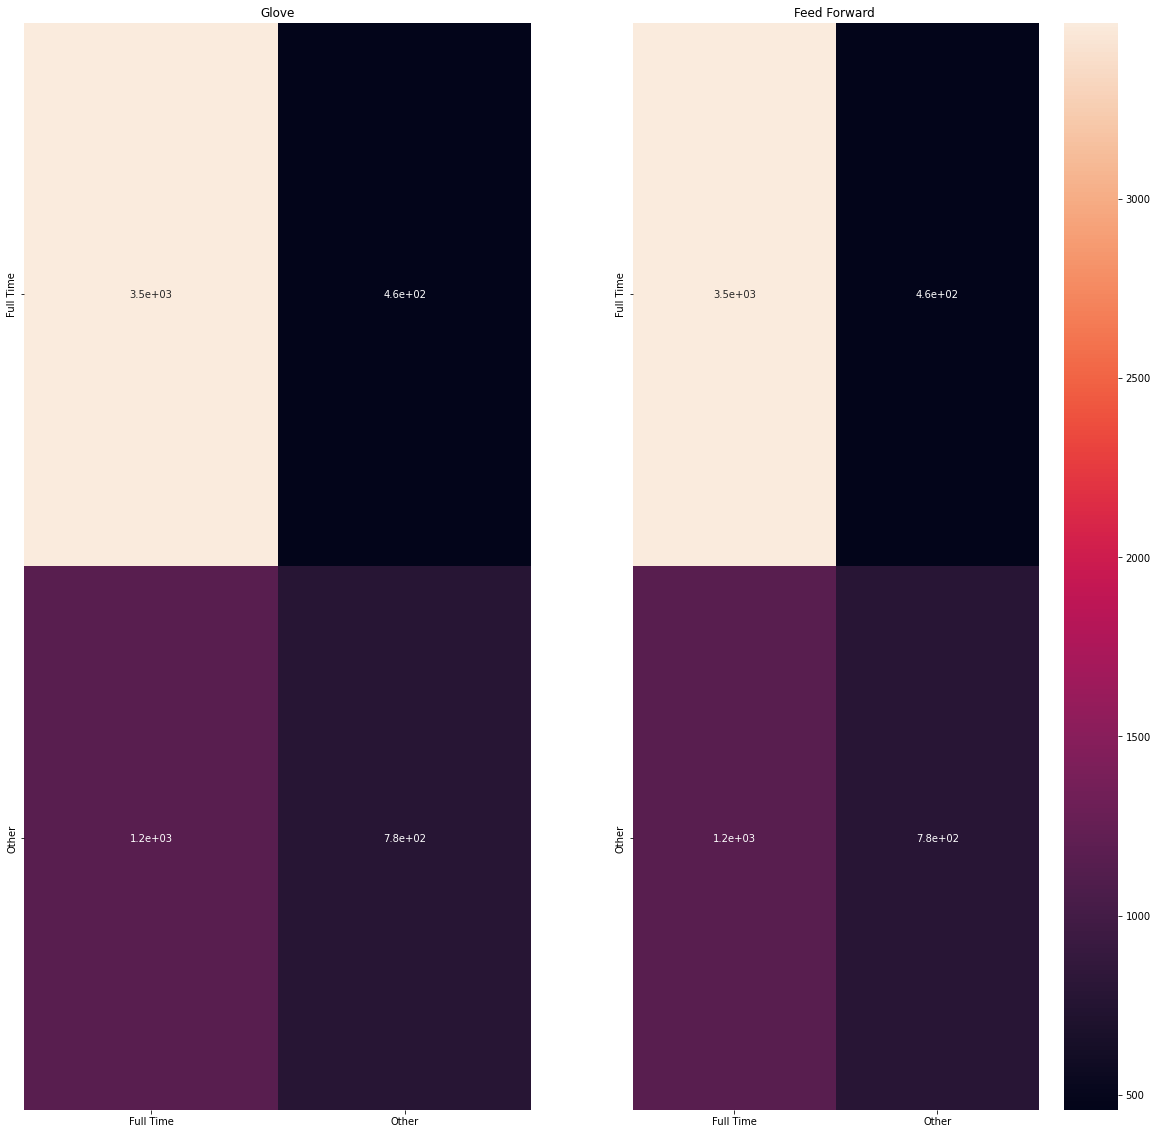

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

classnames = ['Full Time', 'Other']
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20)) 
sns.heatmap(ff_short_word2vec_mat, annot= True, xticklabels=classnames, yticklabels=classnames, ax = ax1, cbar= False )
sns.heatmap(ff_short_glove_mat, annot= True, xticklabels=classnames, yticklabels=classnames, ax = ax2 )
ax1.title.set_text('Word2Vec')
ax1.title.set_text('Glove')
plt.title("Feed Forward ")

### Calculating the evaluation metrics of the CNN classifiers

In [ ]:
cnn_short_glove_report, cnn_short_glove_mat = evaluation(cnn_classifier_short_glove, dataset_short_desc, cnn_args, binary = True)
cnn_long_glove_report, cnn_long_glove_mat = evaluation(cnn_classifier_long_glove, dataset_long_desc, cnn_args, binary = True)

In [ ]:
cnn_short_word2vec_report, cnn_short_word2vec_mat = evaluation(cnn_classifier_short_word2vec, dataset_short_desc, cnn_args, binary = True)
cnn_long_word2vec_report, cnn_long_word2vec_mat = evaluation(cnn_classifier_short_glove, dataset_long_desc, cnn_args, binary = True)

In [ ]:
cnn_short_onehot_report, cnn_short_onehot_mat = evaluation(cnn_classifier_short_one_hot, dataset_short_desc, cnn_args, binary = True)
cnn_long_onehot_report, cnn_short_long_mat = evaluation(cnn_classifier_long_one_hot, dataset_long_desc, cnn_args, binary = True) # this takes about 1.5 mins

In [ ]:
print("{:<10} {:<20} {:<20} {:<20} {:<20} {:<20} {:<20}".format('key', 'SHORT GLOVE', 'LONG GLOVE', 'SHORT WORD2VEC', 'LONG WORD2VEC', 'SHORT ONEHOT', 'LONG ONEHOT'))
for key in cnn_short_glove_report.keys():
    print ("{:<5} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(key,cnn_short_glove_report[key], cnn_long_glove_report[key], 
                                               cnn_short_word2vec_report[key], cnn_long_word2vec_report[key], cnn_short_onehot_report[key], cnn_long_onehot_report[key]))

key        SHORT GLOVE          LONG GLOVE           SHORT WORD2VEC       LONG WORD2VEC       
Recall 0.3174999952316284 0.555831253528595 0.18965516984462738 0.024875622242689133
F1Score 0.41166937351226807 0.6239554286003113 0.27848100662231445 0.048426151275634766
Accuracy 0.6843478083610535 0.7652173638343811 0.6530434489250183 0.6582608819007874
Precision 0.5852534770965576 0.7111111283302307 0.523809552192688 0.9090909361839294


Models with the Top ten tfidf data set perform similar to the baseline model but worse than the feed forward model of the same embedding. This is an unexpected result but can be explained by the fact that the top ten tfidf data has key information stripped from it such that two subsequent words in the data have little to no relation with each other. Thus, convolution can not draw out any usefull information. Hence, feeding this information to a neural network leads to subpar classifiaction.
Surprisingly, the glove embedding has the best performance overal. The expectation was, the word2vec domain specific embedding would outperform all embeddings since domain specific embedding can draw out information that a general embedding cannot.

## Confusion matrices

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
classnames = ['Full Time', 'Other']

Text(0.5, 1.0, 'CNN short glove')

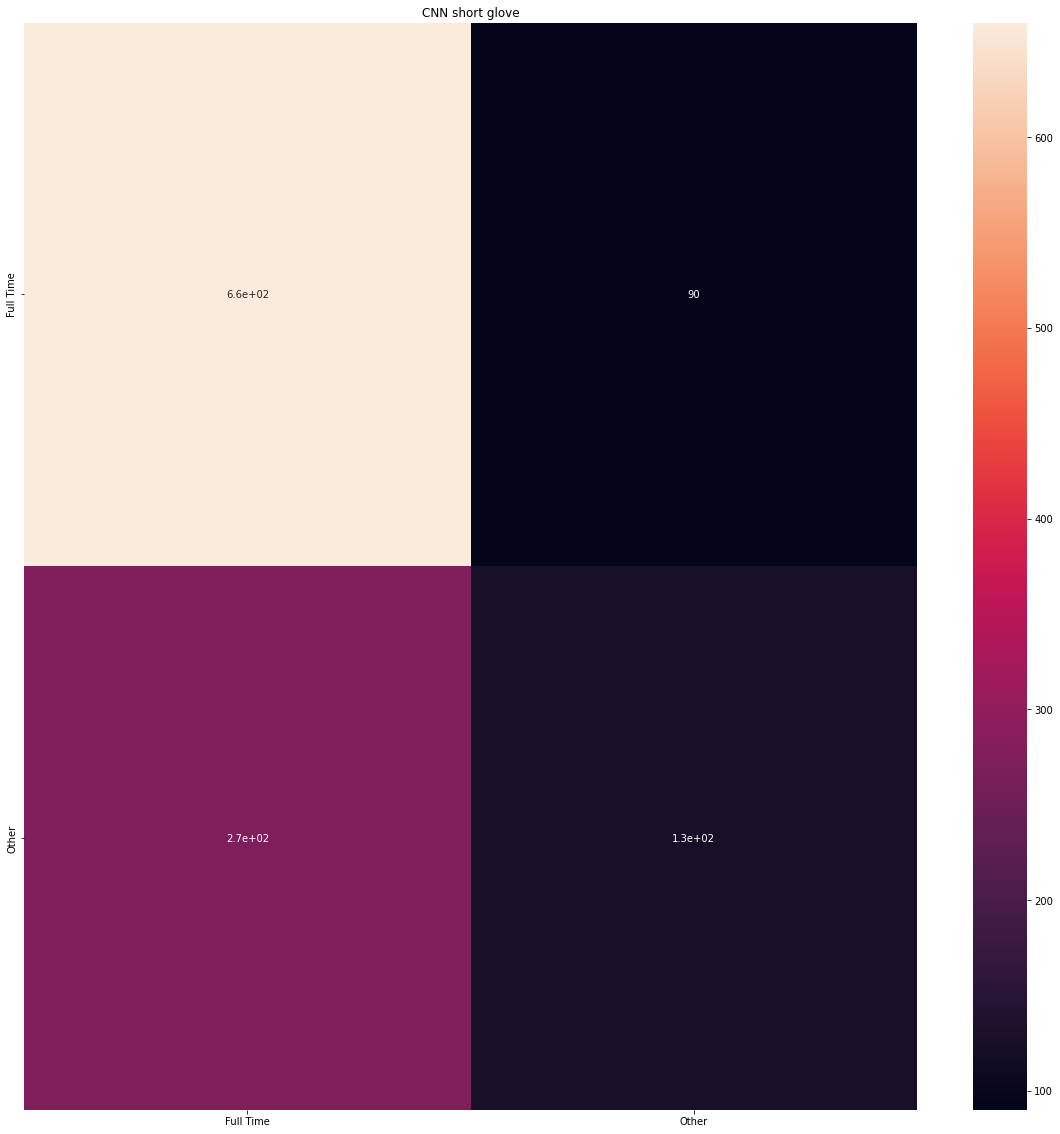

In [ ]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(cnn_short_glove_mat, annot= True, xticklabels=classnames, yticklabels=classnames )
plt.title("CNN short glove")

Text(0.5, 1.0, 'CNN long glove')

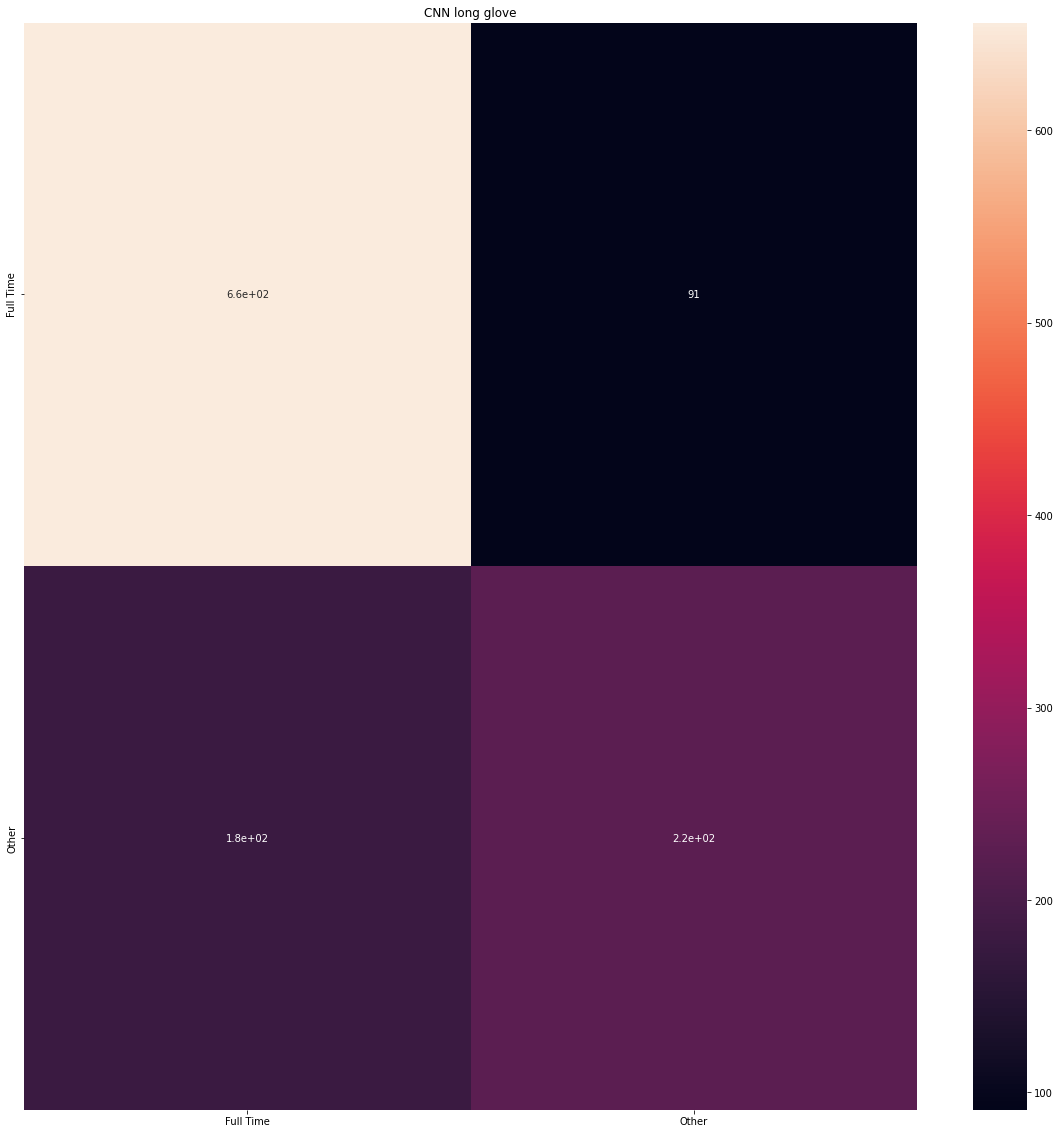

In [ ]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(cnn_long_glove_mat, annot= True, xticklabels=classnames, yticklabels=classnames )
plt.title("CNN long glove")

Text(0.5, 1.0, 'CNN short word2vec')

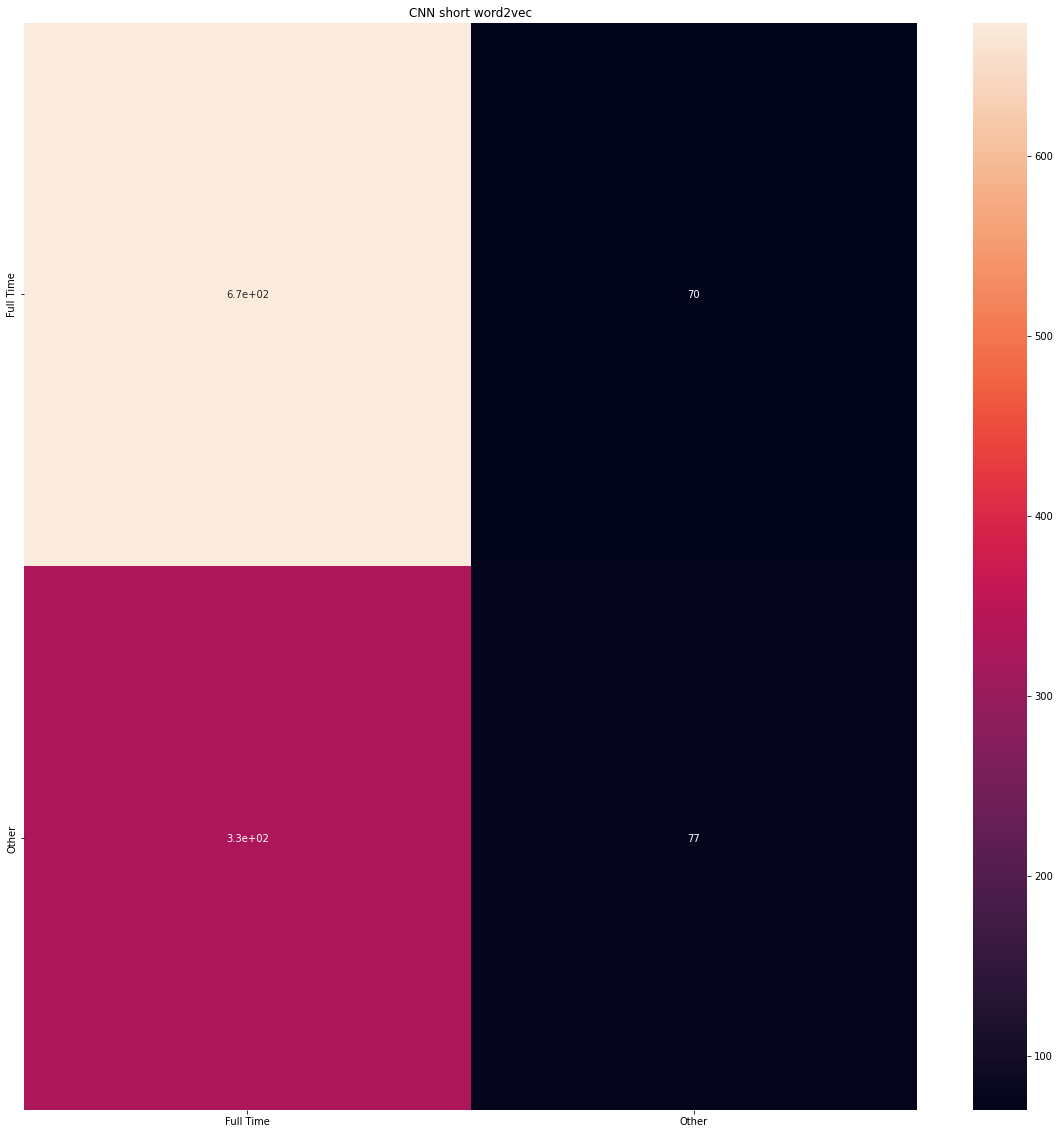

In [ ]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(cnn_short_word2vec_mat, annot= True, xticklabels=classnames, yticklabels=classnames )
plt.title("CNN short word2vec")

Text(0.5, 1.0, 'CNN long word2vec')

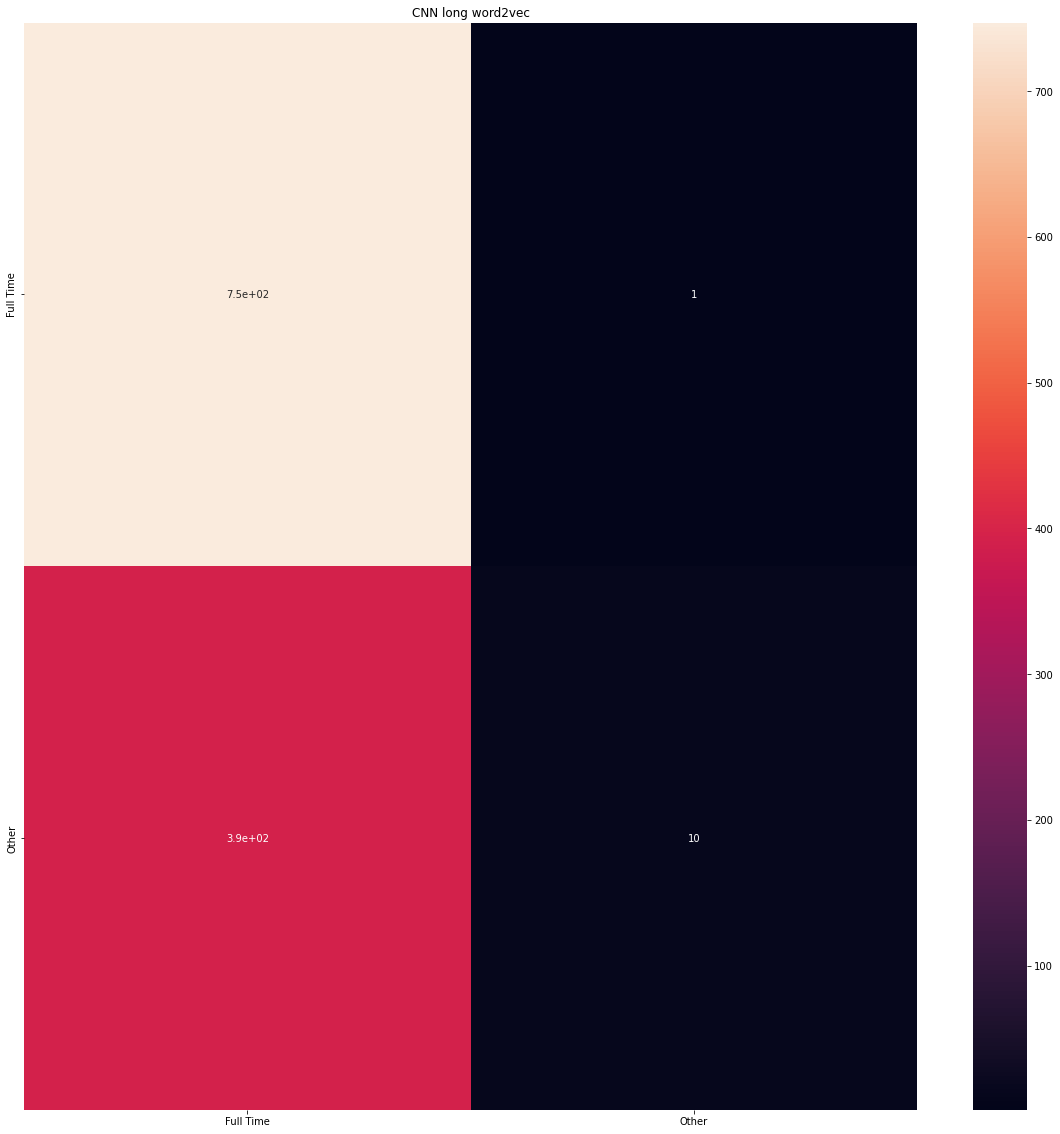

In [ ]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(cnn_long_word2vec_mat, annot= True, xticklabels=classnames, yticklabels=classnames )
plt.title("CNN long word2vec")

Text(0.5, 1.0, 'CNN short one hot')

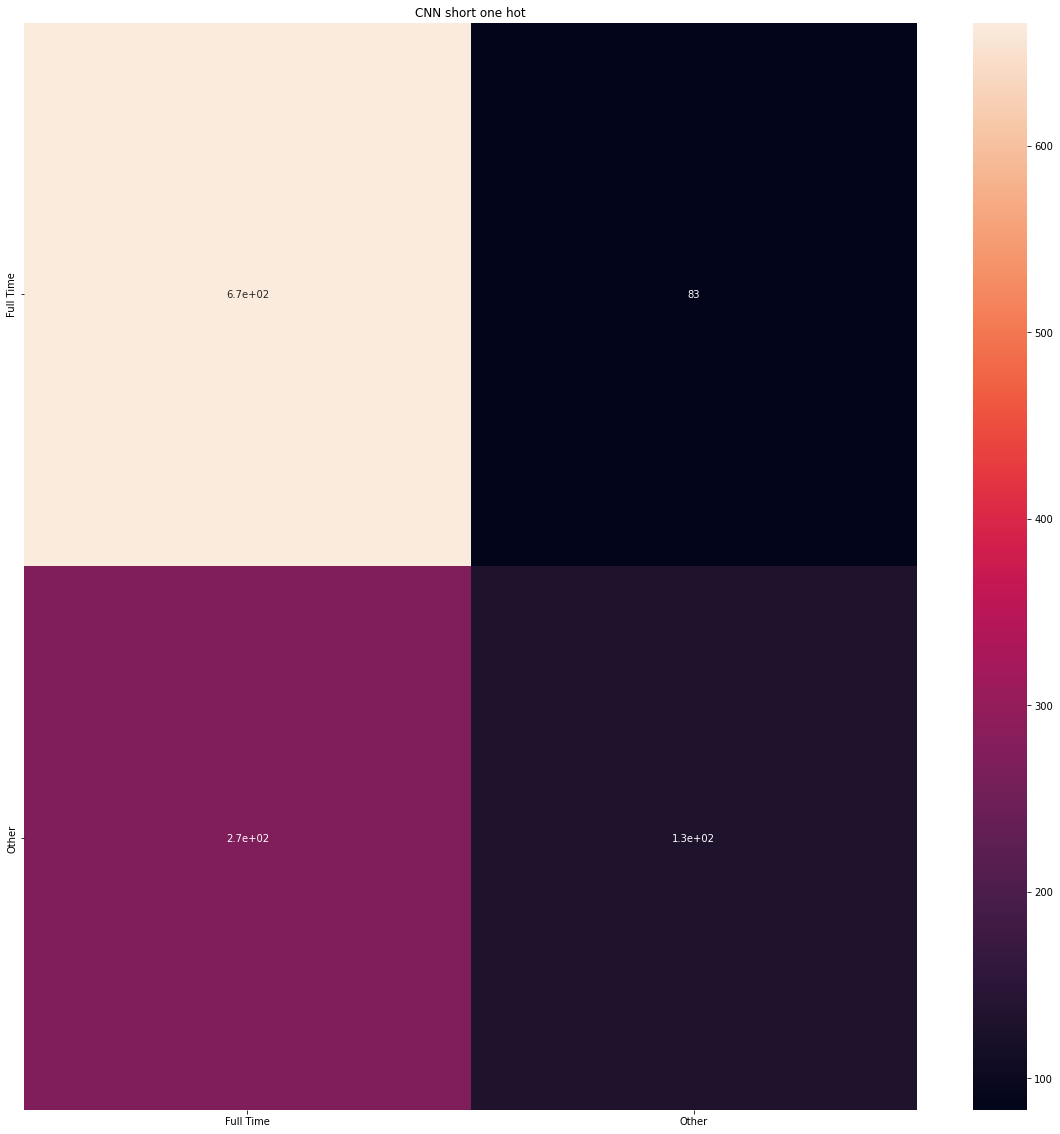

In [ ]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(cnn_short_onehot_mat, annot= True, xticklabels=classnames, yticklabels=classnames )
plt.title("CNN short one hot")

Text(0.5, 1.0, 'CNN short one hot')

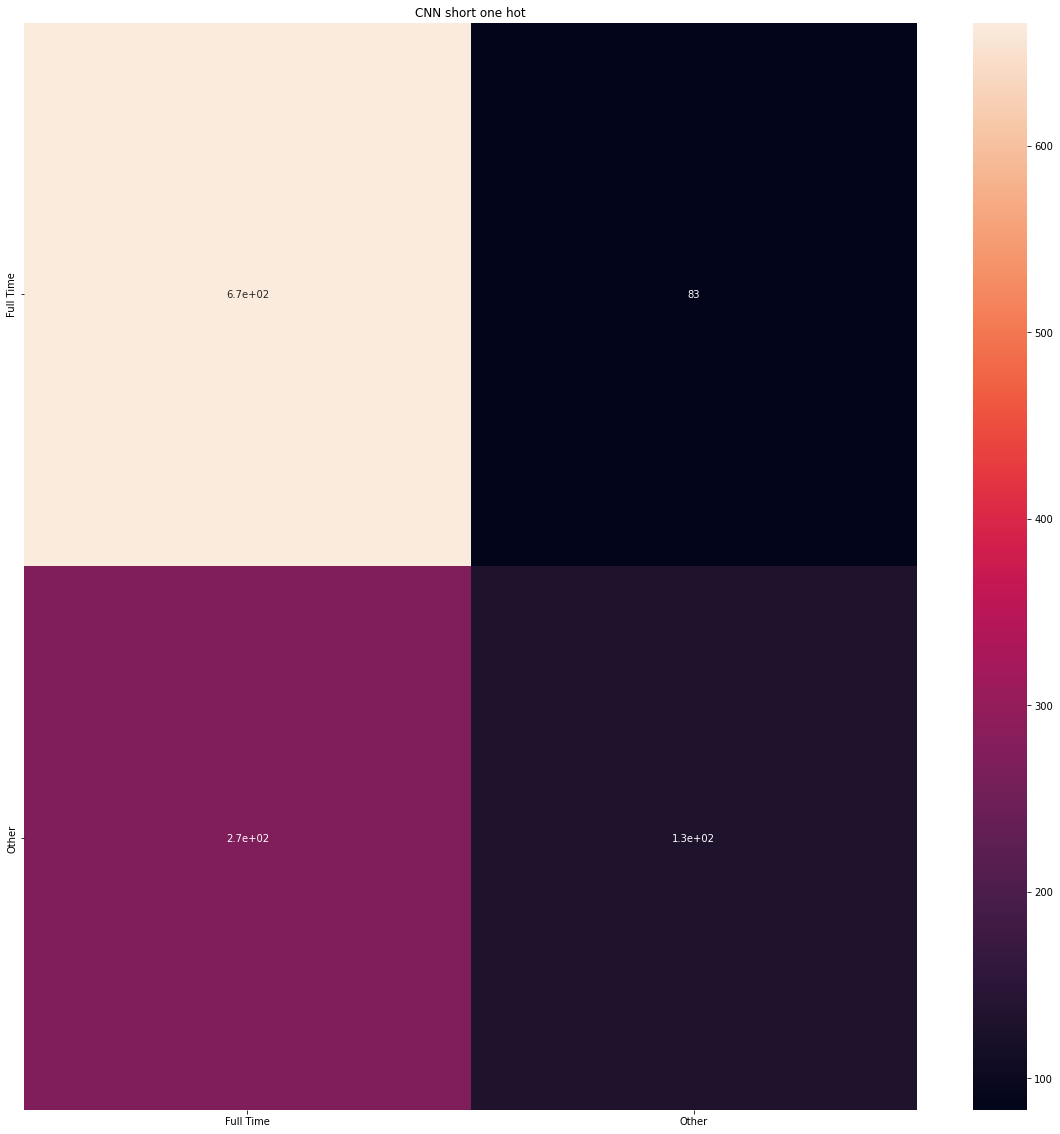

In [ ]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(cnn_long_onehot_mat, annot= True, xticklabels=classnames, yticklabels=classnames )
plt.title("CNN long one hot")

## Discussion

Of the feed forward models trained the domain specific word2vec model embeddings performed the best with an accuracy of 73%. The glove embeddings then had a slightly lower accuracy but still performed above the baseline. Lastly the one hot performed around the same as the rest of the classifiers. 

A possible explanation for the slightly superior performance of the word2vec embeddings is of a sufficiently large dataset and the word2vec model that was trained extracting domain specific semantics. 

With the cnn classifiers the short description dataset performed consistently  worse with around 10% less accuracy similar to the feed forward models that were also trained on the smaller dataset. The domain specific embeddings again had a slight edge on the glove embeddings however had more or less the same performance as the one hot encoded embeddings. The main downside of the one hot encoded embeddings was the far slower training time and ram requirement. 